# Scraping Notícias

In [ ]:
!pip install cloudscraper

In [ ]:
# Importar bibliotecas
import cloudscraper
import re
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
# Carregar base com as urls
urls = pd.read_excel('/content/urls.xlsx', sheet_name ='portaldoholanda')

In [ ]:
# Realizar em máquina local, tendo em vista que o scraping não funciona no Colab
scraper = cloudscraper.create_scraper(delay=10,   browser={'custom': 'ScraperBot/1.0',})

linkMateria = []
tituloMateria = []
dataPublicacao = []
corpoMateria = [] 

for url in urls['urls']:
    try:

        req = scraper.get(url)
        if req.status_code == 200 or 403:
            soup = BeautifulSoup(req.content, "html.parser")
            link = url
            titulo = soup.find('h1',class_="noticia titulo").text
            publicado = soup.find('p',class_="destaque ha").text
            publicado = publicado[:11]
            
            for div in soup.select('[class="corpo"]'):
                p = div.find_all('p')
            corpoMateria.append(p)
        
            linkMateria.append(link)
            tituloMateria.append(titulo)
            dataPublicacao.append(publicado)

    except:
        pass

In [ ]:
# Converter para df
df = pd.DataFrame(list(zip(linkMateria,tituloMateria, dataPublicacao, corpoMateria)), columns=['link','titulo','data', 'materia'])
df.head(3)

,link,titulo,data,materia


# Alternativa

In [ ]:
# Carregar a base, tendo em vista que o scraping não funciona no Colab
df = pd.read_excel('/content/holanda.xlsx')
df.head(3)

,link,titulo,data,materia
0,http://www.portaldoholanda.com.br/assalto/adol...,\n\nAdolescente tem rosto desfigurado após ser...,\n12/01/2018,[<p>Manaus/AM - Um homem foi preso e um menor ...
1,https://www.portaldoholanda.com.br/assaltante/...,"\n\nApós roubar loja, suspeito é perseguido e ...",\n19/06/2018,"[<p>Manaus/AM - Um homem, ainda não identifica..."
2,https://www.portaldoholanda.com.br/espancament...,\n\nHomem é capturado e espancado por moradore...,\n13/07/2018,[<p>Manaus/AM - Um jovem foi espancado na noit...


# Mineração de texto

In [ ]:
# Importar bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [ ]:
# Baixar módulos
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Lista de stopwords customizada
stopWords = []

stopwords_pretext = open('/content/stopwords-portugues.txt', 'r')

with stopwords_pretext as f:
    stopwords_pretext = f.read().splitlines()

stopWords = stopwords_pretext

In [ ]:
# Unir lista customizada com as palavras da NLTK
stopNLTK = stopwords.words('portuguese')
stopWords += stopNLTK

### Funções

In [ ]:
# Função para remover elementos de html
def parser(text):
    return re.sub('<[^<]+?>', '', str(text))

# Função para limpar os textos do título e do subtítulo
def limparTitulos(df):
  replacer = {'\n':' ',"[\[].*?[\]]": "",'[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para limpar o texto das matérias
def limparMateria(df):
  replacer = {'\n':' ','[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’""′‘\\\]':" ", ' +': ' '}
  df = df.replace(replacer, regex=True).apply(lambda x: x.strip()).apply(lambda x: " ".join(x.lower() for x in x.split()))
  df = df.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8', errors='ignore')
  df = df.apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))
  return df

# Função para tokenizar os textos
def tokenizar(df):
  df = df.apply(word_tokenize,language='portuguese') 
  return df  

# Função para contar o número de palavras por texto
def contarPalavras(df):
  lists =  df

  words = []
  for wordList in lists:
    words += wordList
  FreqDist(words)

  # Elencar os x termos mais frequentes
  fdist = FreqDist(words)
  
  # Transformar em df
  termos = pd.DataFrame(list(fdist.items()), columns = ["Termos", "Frequência"]).sort_values(by=['Frequência'], ascending=False)
  
  return termos

# Função para gerar as nuvens de palavras
def gerarNuvem(df):
  df = df.set_index('Termos').to_dict()['Frequência']
  wc = WordCloud(width=800, height=400, max_words=200, background_color = 'white', contour_width=3, contour_color='steelblue').generate_from_frequencies(df)

  plt.figure(figsize=(10, 10))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis('off')
  plt.show()
  return plt.show()

### Pré-processamento

In [ ]:
df['materiaLimpa'] = df.materia.apply(parser)
df['tituloLimpo'] = df.titulo.apply(parser)
df['dataLimpa'] = df['data'].replace(r'\n',' ', regex=True) 

df['tituloLimpo'] = limparTitulos(df['tituloLimpo'])
df['cleanmateriaLimpa'] = limparMateria(df['materiaLimpa'])

## Tokenização e frequências

In [ ]:
df['tokenizeTitulo'] = tokenizar(df['tituloLimpo'])
df['tokenizeMateria'] = tokenizar(df['cleanmateriaLimpa'])

In [ ]:
frequenciaTitulo = contarPalavras(df['tokenizeTitulo'])
frequenciaTitulo.head(10) 

,Termos,Frequência
3,espancado,27
7,suspeito,23
10,homem,20
4,populares,19
13,assalto,17
20,surra,8
94,assaltar,6
12,moradores,6
14,estuprar,5
34,leva,5


In [ ]:
frequenciaMateria = contarPalavras(df['tokenizeMateria'])
frequenciaMateria.head(10)

,Termos,Frequência
0,homem,90
20,policia,71
81,suspeito,62
11,zona,56
9,bairro,55
17,populares,54
28,rua,41
253,vitima,37
14,espancado,35
4,noite,34


## Nuvem de palavras

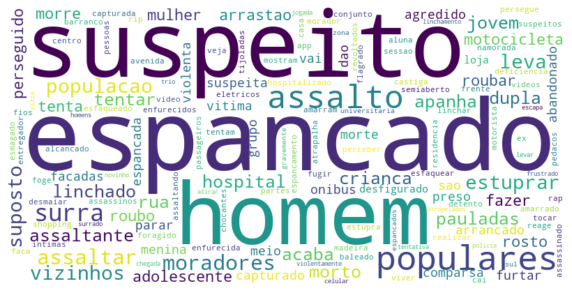

In [ ]:
gerarNuvem(frequenciaTitulo)

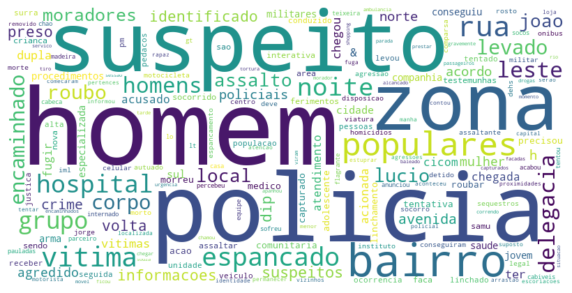

In [ ]:
gerarNuvem(frequenciaMateria)